In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [2]:
import deepinv as dinv
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods
from deepinv.models.complex import to_complex_denoiser

In [4]:
BASE_DIR = Path(".")
RESULTS_DIR = BASE_DIR / "results"
# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

'cpu'

In [10]:
# Set up the variable to fetch dataset and operators.
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

torch.Size([1, 1, 99, 99])

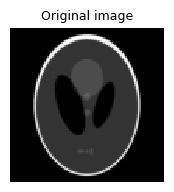

In [11]:
plot(x, titles="Original image")

In [12]:
# We use the original image as the phase information for the complex signal.
# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [ ]:
oversampling_ratio = 2.0
img_shape = x.shape[1:]
m = int(oversampling_ratio * torch.prod(torch.tensor(img_shape)))

noise_level_img = 0.05  # Gaussian Noise standard deviation for the degradation
n_channels = 1  # 3 for color images, 1 for gray-scale images
physics = dinv.physics.RandomPhaseRetrieval(
    m=m,
    img_shape=img_shape,
    noise_model=dinv.physics.GaussianNoise(sigma=noise_level_img),
)
y = physics(x_phase)

In [101]:
data_fidelity = L2()
# Step size for the gradient descent
stepsize = 0.20 * oversampling_ratio / 5.0
num_iter = 3000

loss_init: tensor([245.7525])
loss_final: tensor([0.4771])


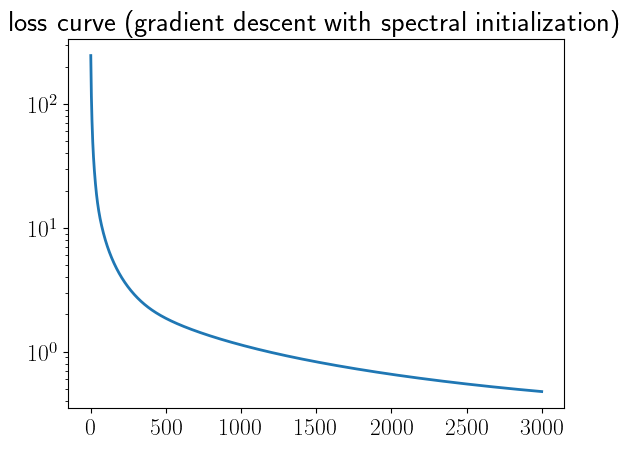

In [102]:
# spectral methods
x_phase_gd_spec = physics.A_dagger(y,n_iter=300)
x_phase_gd_spec = x_phase_gd_spec * torch.sqrt(y.sum())
loss_hist = []
for _ in range(num_iter):
    x_phase_gd_spec = x_phase_gd_spec - stepsize * data_fidelity.grad(x_phase_gd_spec, y, physics)
    loss_hist.append(data_fidelity(x_phase_gd_spec, y, physics))

print("loss_init:",loss_hist[0])
print("loss_final:",loss_hist[-1])
plt.plot(loss_hist)
plt.yscale('log')
plt.title('loss curve (gradient descent with spectral initialization)')
plt.show()

Image 0, channel 0 does not have a global phase shift.


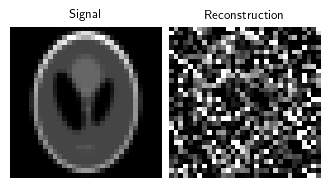

In [104]:
# correct possible global phase shifts
x_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_gd_spec) / torch.pi + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')

# structured Case

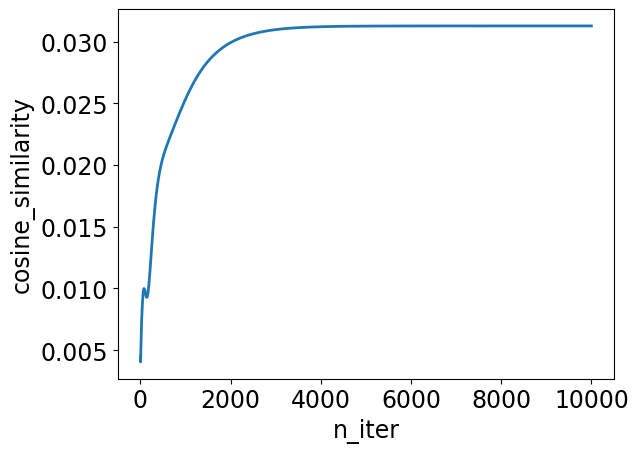

In [30]:
physics = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1,99,99),
    output_shape=(1,99,99),
    dtype=torch.cfloat,
    device=device,
)

y = physics(x_phase)
torch.allclose(physics.B_adjoint(physics.B(x_phase)), x_phase)

x_phase_spec, metrics = spectral_methods(y, physics, n_iter=10000,x_true=x_phase,log=True)
plt.plot(metrics)
plt.xlabel('n_iter')
plt.ylabel('cosine_similarity')
plt.show()

In [9]:
x_phase_spec = physics.A_adjoint(y, n_iter=2500)
a = x_phase_spec.flatten()
print(a.shape)
print(a.dtype)
print(torch.dot(a.conj(),a))
print(torch.sqrt(torch.dot(a.conj(), a).real))
print(x_phase_spec.norm())
cosine_similarity(x_phase_spec, x_phase)

torch.Size([961])
torch.complex64
tensor(3480.9995+0.j)
tensor(59.0000)
tensor(59.)
tensor(59.0000)
tensor(31.0000)
tensor(1538.6354)


tensor(0.8412)

In [39]:
memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
memory_available
idx = np.argmax(memory_available)
idx

0

In [40]:
import os
os.name

'posix'

In [10]:
test = torch.randn(10,dtype=torch.cfloat,device=device)
print(test)
print(test.conj())
print(torch.sum(test.conj()*test))
print(torch.dot(test.conj(),test))

tensor([ 0.7460+0.5475j,  0.4745+0.6632j, -0.8731-1.3012j, -0.2676+0.5308j,
         0.3194+0.3366j,  0.8365+1.1414j, -0.5781+0.1419j, -0.6656+0.1508j,
         0.5920+0.1420j, -0.0153+0.3357j])
tensor([ 0.7460-0.5475j,  0.4745-0.6632j, -0.8731+1.3012j, -0.2676-0.5308j,
         0.3194-0.3366j,  0.8365-1.1414j, -0.5781-0.1419j, -0.6656-0.1508j,
         0.5920-0.1420j, -0.0153-0.3357j])
tensor(7.8516+2.3904e-09j)
tensor(7.8516+0.j)


Image 0, channel 0 does not have a global phase shift.


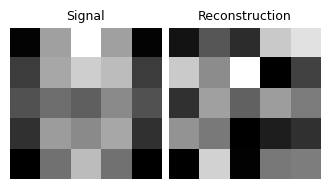

Cosine similarity: tensor(0.5795, device='cuda:0')


In [31]:
# correct possible global phase shifts
x_spec = correct_global_phase(x_phase_spec, x_phase)
# extract phase information and normalize to the range [0, 1]
x_spec = torch.angle(x_spec) / torch.pi + 0.5
plot([x, x_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')
print("Cosine similarity:", cosine_similarity(x, x_spec))

In [32]:
x_phase

tensor([[[[0.0370-0.9993j, 0.5472-0.8370j, 0.7905-0.6124j, 0.5472-0.8370j,
           0.0370-0.9993j],
          [0.2319-0.9727j, 0.5677-0.8233j, 0.6737-0.7390j, 0.6269-0.7791j,
           0.2319-0.9727j],
          [0.3032-0.9529j, 0.3955-0.9185j, 0.3497-0.9369j, 0.4839-0.8751j,
           0.3032-0.9529j],
          [0.1958-0.9806j, 0.5369-0.8437j, 0.4839-0.8751j, 0.5677-0.8233j,
           0.1958-0.9806j],
          [0.0246-0.9997j, 0.4067-0.9135j, 0.6269-0.7791j, 0.4067-0.9135j,
           0.0246-0.9997j]]]], device='cuda:0')

In [38]:
(x_phase_spec / x_phase).var()

tensor(0.0003, device='cuda:0')

In [224]:
data_fidelity = L2()

x_phase_spec = physics.A_adjoint(y, n_iter=2500)

data_fidelity.grad(x_phase_spec, y, physics).mean().norm()

tensor(10.2499, device='cuda:0')

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [02:41<00:00,  1.08s/it]


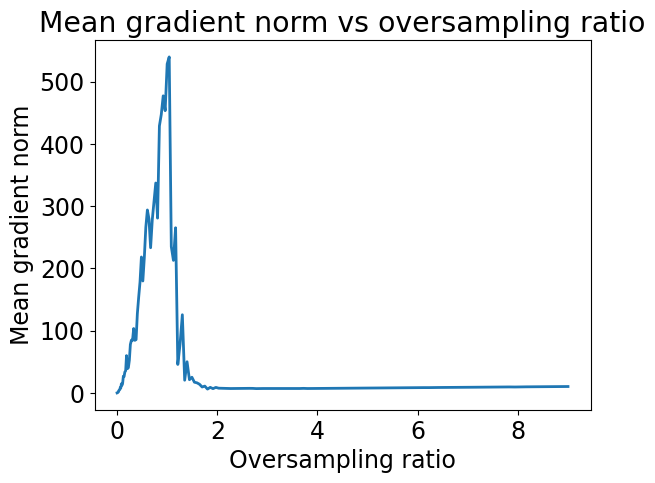

In [184]:
oversampling_ratios = []
mean_gradient = []

for i in tqdm(range(1, 299, 2)):
    physics = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1,99,99),
    output_shape=(1,i,i),
    dtype=torch.cfloat,
    device=device,
) 
    y = physics(x_phase)
    oversampling_ratios.append(physics.oversampling_ratio.item())
    mean_gradient.append(data_fidelity.grad(physics.A_adjoint(y, n_iter=2500), y, physics).mean().norm().item())

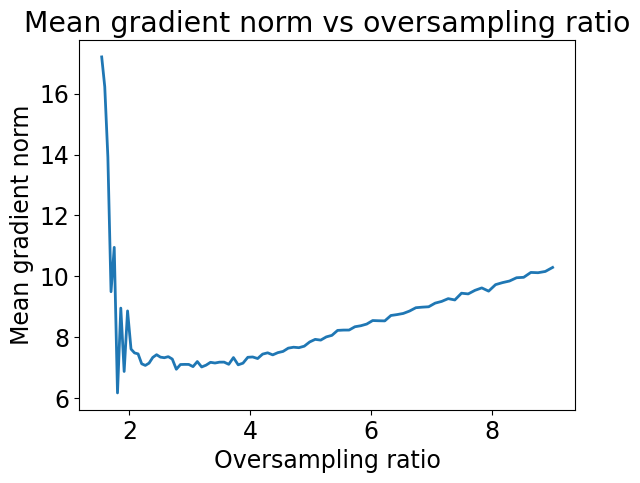

In [218]:
plt.plot(oversampling_ratios[61:], mean_gradient[61:])
plt.xlabel('Oversampling ratio')
plt.ylabel('Mean gradient norm')
plt.title('Mean gradient norm vs oversampling ratio')
plt.show()

In [210]:
physics.oversampling_ratio

tensor(2.0285)

In [211]:
def spectral_methods_wrapper(y, physics, **kwargs):
    x = spectral_methods(y, physics, n_iter=2500, **kwargs)
    z = spectral_methods(y, physics, n_iter=2500, **kwargs)
    return {"est": (x, z)}

In [225]:
# Algorithm parameters
data_fidelity = L2()
prior = dinv.optim.prior.Zero()
params_algo = {"stepsize": 0.006*physics.oversampling_ratio.item(), "g_params": 0.00}
#params_algo = {"stepsize": 0.05, "g_params": 0.00}
max_iter = 10000
early_stop = True
verbose = True

# Instantiate the algorithm class to solve the IP problem.
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

# Run the algorithm
x_phase_grad, metrics = model(y, physics, x_gt=x_phase, compute_metrics=True)

Iteration 944, current converge crit. = 9.97E-06, objective = 1.00E-05 


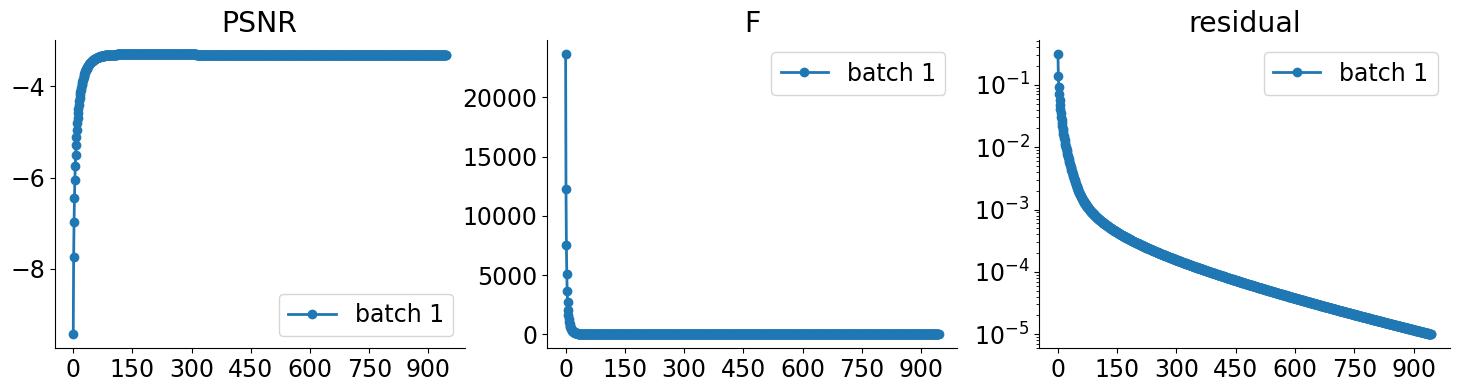

In [226]:
plot_curves(metrics, show=True)

Image 0, channel 0 has a constant global phase shift.


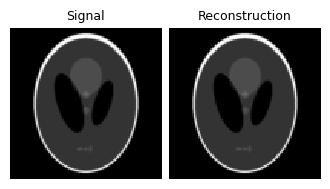

Cosine similarity: tensor(1.0000, device='cuda:0')


In [227]:
# correct possible global phase shifts
x_gd_spec = correct_global_phase(x_phase_grad, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_gd_spec) / torch.pi + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')
print("Cosine similarity:", cosine_similarity(x, x_gd_spec))